<a id="subsection-one"></a>
## Preparing the Data

In [2]:
library(dplyr)
library(ggplot2)
location <- "../input/factors-affecting-campus-placement/Placement_Data_Full_Class.csv"
placement.df <- read.csv(location)
# select only relevant columns
placement.lr <- placement.df %>% select(ends_with("_p"), -etest_p, status)
table(placement.lr$status)
contrasts(placement.lr$status) # to check how a variable have been dummyfied
# we need Not Placed class to be coded as 1 (positive)
placement.lr$status <- ifelse(placement.lr$status == "Not Placed", 1, 0)
table(placement.lr$status)


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union





Not Placed     Placed 
        67        148 

,Placed
Not Placed,0
Placed,1



  0   1 
148  67 

<a id="subsection-two"></a>
## Dividing the data into training and validation data sets

In [3]:
# Train and Test data
library(caTools) # to split data into train and test
set.seed(101)
sample <- sample.split(placement.lr$status, SplitRatio = 0.80)
train.lr = subset(placement.lr, sample == TRUE)
test.lr = subset(placement.lr, sample == FALSE)
#check the splits
prop.table(table(train.lr$status))
prop.table(table(test.lr$status))


        0         1 
0.6860465 0.3139535 


        0         1 
0.6976744 0.3023256 

## Building the model - Simple logistic regression


In [5]:
# Train the model
model.lr <- glm(status ~ degree_p, family = binomial, data = train.lr)
summary(model.lr)



Call:
glm(formula = status ~ degree_p, family = binomial, data = train.lr)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-1.5666  -0.7899  -0.4726   0.9010   2.6407  

Coefficients:
            Estimate Std. Error z value Pr(>|z|)    
(Intercept) 11.43688    2.24817   5.087 3.63e-07 ***
degree_p    -0.18851    0.03509  -5.372 7.79e-08 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 214.05  on 171  degrees of freedom
Residual deviance: 173.35  on 170  degrees of freedom
AIC: 177.35

Number of Fisher Scoring iterations: 5


In [6]:
# prediction
lr.pred <- predict(model.lr, newdata = test.lr, type = "response")
head(lr.pred)
# The probabilities always refer to the class dummy-coded as “1”
head(test.lr$status)


15         17         22         25         33         35 
0.88198047 0.28303502 0.01008494 0.03139780 0.25345579 0.83675747

[1] 1 0 0 0 0 1

<a id="subsection-five"></a>
## Classification Table – Confusion Matrix




Attaching package: ‘gplots’


The following object is masked from ‘package:stats’:

    lowess




15 17 22 25 33 35 
 1  0  0  0  0  1

lr.pred.class
 0  1 
34  9 


 0  1 
30 13 

   lr.pred.class
     0  1
  0 30  0
  1  4  9

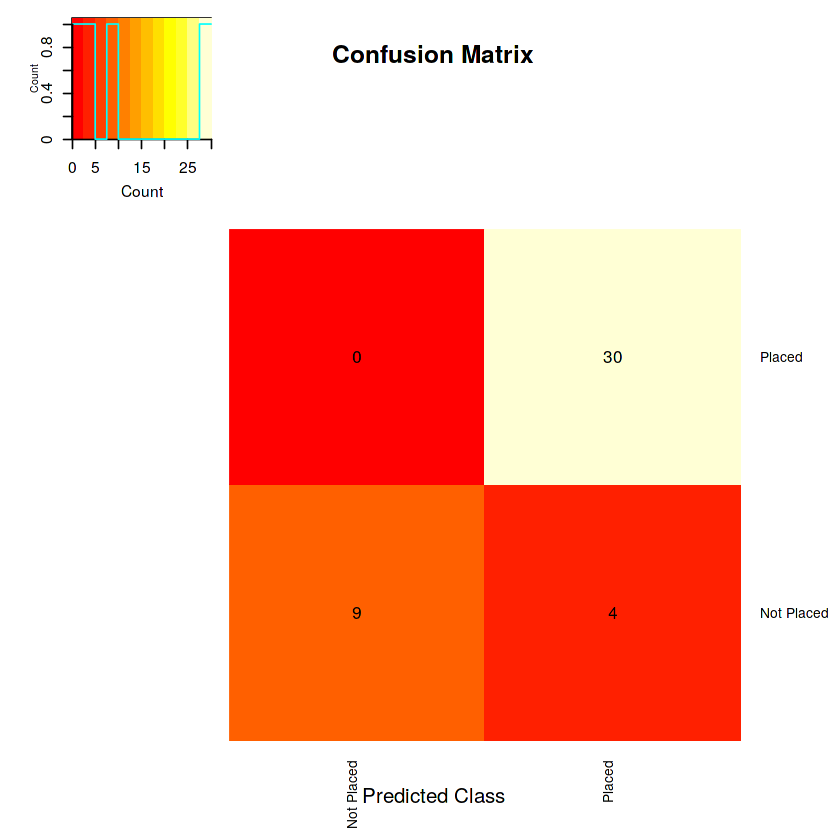

In [8]:
# Classification Table
# categorize into groups based on the predicted probability
library(gplots)

lr.pred.class <- ifelse(lr.pred>=0.5, 1, 0)
head(lr.pred.class)
table(lr.pred.class)
table(test.lr$status)
conf.matrix <- table(test.lr$status, lr.pred.class)
conf.matrix

#format(conf.matrix, digits = 0)  

library(gplots)

lr.pred.class <- ifelse(lr.pred >= 0.5, 1, 0)
conf.matrix <- table(test.lr$status, lr.pred.class)
rownames(conf.matrix) <- c("Placed", "Not Placed")
colnames(conf.matrix) <- c("Placed", "Not Placed")

# Create the heatmap with color gradient and colorbar
heatmap.2(conf.matrix, 
           col = heat.colors(12),  # Example color palette
           dendrogram = "none", 
           key.title = NA,  # Remove key title as it's not applicable here
           key.xlab = "Count",  # Label for the color key
           key.ylab = NULL,  # No label on the color key's y-axis
           cellnote = conf.matrix,
           notecol = "black",
           trace = "none",  # Remove grid lines
           cexRow = 0.8,  # Adjust row name size
           cexCol = 0.8   # Adjust column name size
)

# Customize axis labels
title(main = "Confusion Matrix", col.main = "black")
title(xlab = "Predicted Class", col.lab = "black")
title(ylab = "True Class", col.lab = "black")


In [9]:
# model accuracy
mean((test.lr$status == lr.pred.class))

[1] 0.9069767

   lr.pred.class1
     0  1
  0 27  3
  1  2 11

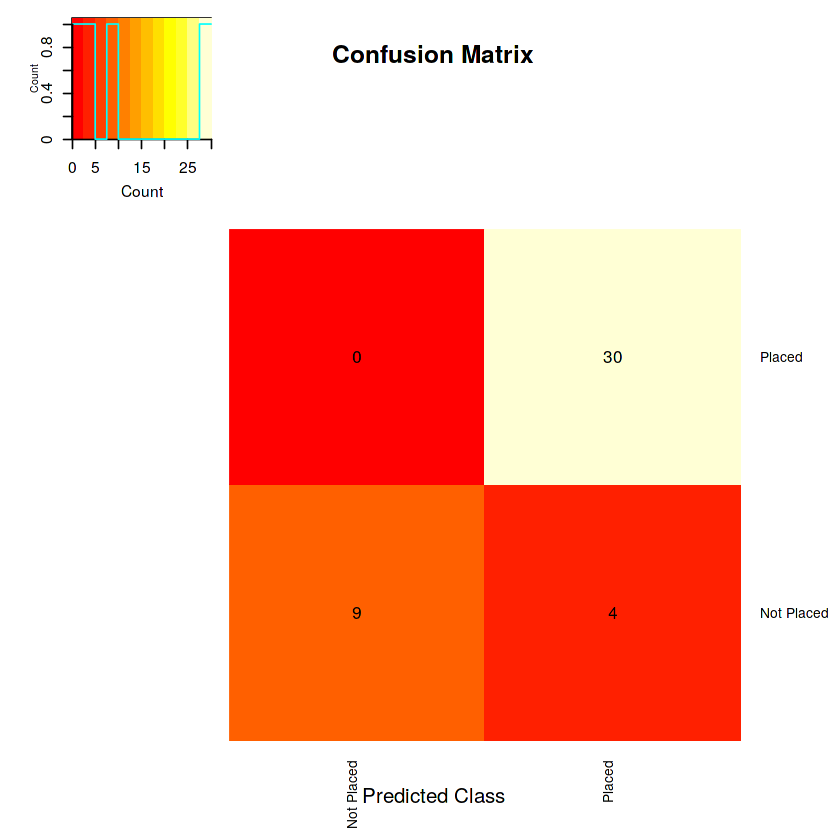

In [10]:
# different cut-off
lr.pred.class1 <- ifelse(lr.pred>=0.35, 1, 0)
conf.matrix1 <- table(test.lr$status, lr.pred.class1)
conf.matrix1
rownames(conf.matrix) <- c("Placed", "Not Placed")
colnames(conf.matrix) <- c("Placed", "Not Placed")

# Create the heatmap with color gradient and colorbar
heatmap.2(conf.matrix, 
           col = heat.colors(12),  # Example color palette
           dendrogram = "none", 
           key.title = NA,  # Remove key title as it's not applicable here
           key.xlab = "Count",  # Label for the color key
           key.ylab = NULL,  # No label on the color key's y-axis
           cellnote = conf.matrix,
           notecol = "black",
           trace = "none",  # Remove grid lines
           cexRow = 0.8,  # Adjust row name size
           cexCol = 0.8   # Adjust column name size
)

# Customize axis labels
title(main = "Confusion Matrix", col.main = "black")
title(xlab = "Predicted Class", col.lab = "black")
title(ylab = "True Class", col.lab = "black")


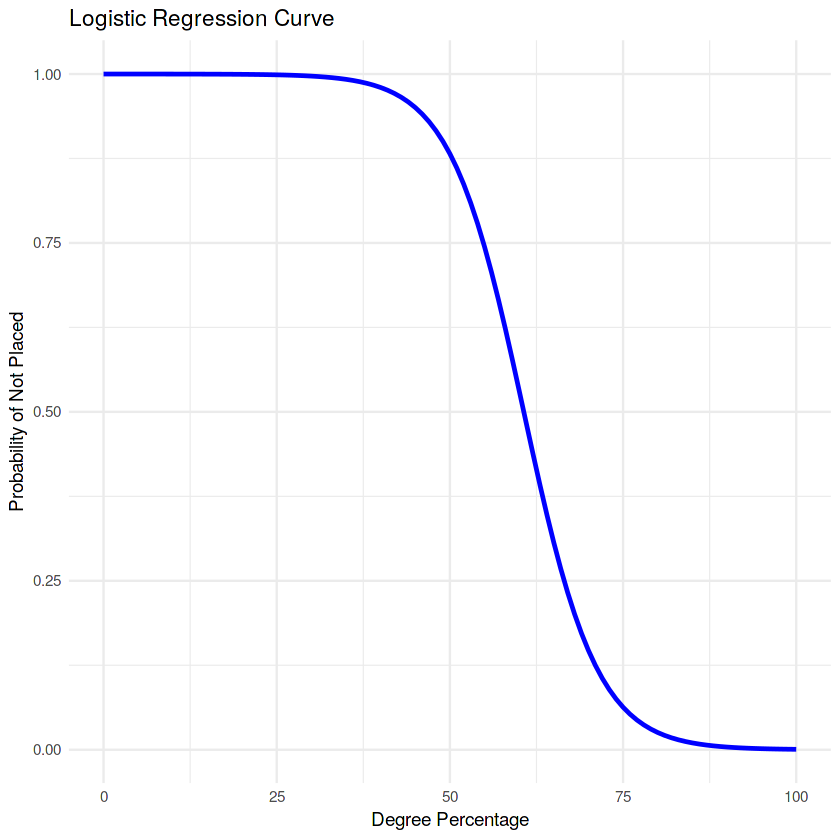

In [11]:
library(ggplot2)

# Generate data for plotting the logistic function
degree_percentage <- seq(0, 100, by = 1)
log_odds <- 11.43688 - 0.18851 * degree_percentage
probability <- exp(log_odds) / (1 + exp(log_odds))

# Create a data frame
logistic_data <- data.frame(degree_percentage, probability)

# Plot the logistic function
ggplot(logistic_data, aes(x = degree_percentage, y = probability)) +
  geom_line(color = "blue", size = 1) +
  labs(x = "Degree Percentage", y = "Probability of Not Placed") +
  ggtitle("Logistic Regression Curve") +
  theme_minimal()
